In [2]:
! pip install pymagnitude pytorch_pretrained_bert tensorboardcolab -q

     |████████████████████████████████| 5.4MB 3.9MB/s 
     |████████████████████████████████| 133kB 48.4MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from scipy import spatial
from sklearn.manifold import TSNE
from tensorboardcolab import TensorBoardColab
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook as tqdm

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

RED, BLUE = '#FF4136', '#0074D9'

Using TensorFlow backend.


In [4]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [5]:
word2idx = {word: idx for idx, word in enumerate(sorted(set(words)))}
word2idx

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

In [6]:
idxs = torch.LongTensor([word2idx[word] for word in sentence.split()])
idxs

tensor([7, 6, 0, 2, 3, 5, 7, 4, 1])

In [7]:
embedding_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=3)
embeddings = embedding_layer(idxs)
embeddings, embeddings.shape

(tensor([[-1.9391,  0.0103,  0.1041],
         [-0.6530, -0.3374, -0.7447],
         [ 1.8776, -0.8010, -0.7647],
         [-0.2534,  0.9037,  0.0338],
         [-1.2020, -0.0079, -0.6353],
         [-1.2267, -0.8425,  1.7056],
         [-1.9391,  0.0103,  0.1041],
         [-0.5909, -1.1822, -2.0278],
         [ 0.4273,  1.9525, -0.0419]], grad_fn=<EmbeddingBackward>),
 torch.Size([9, 3]))

In [8]:
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude glove/

--2020-02-17 06:10:22--  http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.236.10
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.236.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102670336 (98M) [binary/octet-stream]
Saving to: ‘glove.6B.50d.magnitude’

glove.6B.50d.magnit 100%[===================>]  97.91M  36.8MB/s    in 2.7s    

2020-02-17 06:10:25 (36.8 MB/s) - ‘glove.6B.50d.magnitude’ saved [102670336/102670336]

--2020-02-17 06:10:25--  http://glove/
Resolving glove (glove)... failed: Name or service not known.
wget: unable to resolve host address ‘glove’
FINISHED --2020-02-17 06:10:25--
Total wall clock time: 3.0s
Downloaded: 1 files, 98M in 2.7s (36.8 MB/s)


In [9]:
!ls -al

total 100280
drwxr-xr-x 1 root root      4096 Feb 17 06:10 .
drwxr-xr-x 1 root root      4096 Feb 17 06:07 ..
drwxr-xr-x 1 root root      4096 Feb 13 17:15 .config
-rw-r--r-- 1 root root 102670336 Oct 27  2018 glove.6B.50d.magnitude
drwxr-xr-x 1 root root      4096 Feb  5 18:37 sample_data


In [10]:
!wc -l glove.6B.50d.magnitude

652242 glove.6B.50d.magnitude


In [0]:
glove_vectors = Magnitude('glove/glove.6B.50d.magnitude')

In [12]:
glove_embeddings = glove_vectors.query(words)
glove_embeddings[0], glove_embeddings.shape

(array([ 8.414140e-02,  5.025940e-02, -8.301820e-02,  2.449760e-02,
         6.950120e-02, -8.949000e-03, -1.000196e-01, -3.595540e-02,
        -1.329000e-04, -1.321705e-01,  5.604660e-02, -2.972530e-02,
        -1.120752e-01,  2.950590e-02, -1.914200e-03,  2.346700e-03,
         2.054020e-02, -2.574970e-02, -1.699536e-01, -2.451980e-02,
        -3.382000e-03, -6.698900e-02, -3.124100e-02, -4.656160e-02,
        -3.861040e-02, -3.788981e-01, -1.544861e-01,  1.993850e-02,
        -8.479560e-02, -3.930490e-02,  8.066102e-01, -3.742880e-02,
        -1.052513e-01, -6.377240e-02,  1.192000e-04,  1.498600e-03,
         3.578630e-02, -3.199990e-02,  2.423800e-03, -1.091480e-02,
        -6.012890e-02, -3.170200e-02, -6.996620e-02, -9.186500e-03,
        -8.907520e-02,  3.781330e-02,  5.606000e-04, -3.706050e-02,
        -2.317710e-02, -1.581798e-01], dtype=float32), (9, 50))

In [0]:
def cosine_similarity(word1, word2):
  vector1, vector2 = glove_vectors.query(word1), glove_vectors.query(word2)
  return 1 - spatial.distance.cosine(vector1.reshape((1,-1)), vector2.reshape((1,-1)))

In [14]:
word_pairs = [
              ('dog', 'cat'),
              ('tree', 'cat'), 
              ('tree', 'leaf'),
              ('king', 'queen'),
]

for word1, word2 in word_pairs:
  print(f'Similarity between "{word1}" and "{word2}" :\t{cosine_similarity(word1, word2):.2f}')

Similarity between "dog" and "cat" :	0.92
Similarity between "tree" and "cat" :	0.57
Similarity between "tree" and "leaf" :	0.74
Similarity between "king" and "queen" :	0.78


In [0]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]

HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [16]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(glove_vectors.query(ANIMALS+HOUSEHOLD_OBJECTS))
tsne_words_embedded.shape

(35, 2)

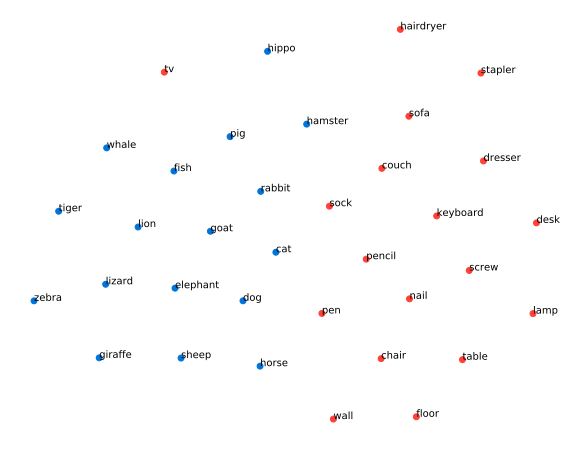

In [17]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(10, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
  if label in ANIMALS:
    color = BLUE
  elif label in HOUSEHOLD_OBJECTS:
    color = RED

  ax.scatter(x[i], y[i], c = color)
  ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

In [18]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

tbc = TensorBoardColab()

vectors = glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS)
with SummaryWriter(log_dir='Graph/') as writer:
  writer.add_embedding(mat=vectors, metadata=ANIMALS+HOUSEHOLD_OBJECTS)

Wait for 8 seconds...
TensorBoard link:
https://73094f49.ngrok.io


In [19]:
# %tensorboard --logdir=Graph/
%reload_ext tensorboard
%tensorboard --logdir=Graph/

In [20]:
!pip install gin-config==0.1.1 

     |████████████████████████████████| 40kB 3.3MB/s 
  Created wheel for gin-config: filename=gin_config-0.1.1-cp36-none-any.whl size=38331 sha256=bc2beba14701cf7d392d62fd5d8407e33bb24221d0e2f20fa65e6d162cce0713
  Stored in directory: /root/.cache/pip/wheels/65/92/44/869d6c5d448044e10b0a68edaadec2bb21339c47362c2e8bcb
Successfully built gin-config
  Found existing installation: gin-config 0.3.0
    Uninstalling gin-config-0.3.0:
      Successfully uninstalled gin-config-0.3.0


In [21]:
!pip install tensorboardcolab==0.0.11

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.11-cp36-none-any.whl size=3397 sha256=1148c926248782db90da6dcd64b05d627de23438e8a9b18505fed54e644eb843
  Stored in directory: /root/.cache/pip/wheels/08/5c/77/b460d62566770e9dcff502e2d6a4747b664ec482693752e4fe
Successfully built tensorboardcolab
  Found existing installation: tensorboardcolab 0.0.22
    Uninstalling tensorboardcolab-0.0.22:
      Successfully uninstalled tensorboardcolab-0.0.22


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def to_bert_embeddings(text, return_tokens=False):
  if isinstance(text, list):
    # Already tokenized
    tokens = tokenizer.tokenize(' '.join(text))
  else:
    # Need to tokenize
    tokens = tokenizer.tokenize(text)

  tokens_with_tags = ['[CLS]'] + tokens + ['[SEP]']
  indices = tokenizer.convert_tokens_to_ids(tokens_with_tags)
  print(indices)

  out = model(torch.LongTensor(indices).unsqueeze(0)) # type(out) == tuple
  print(np.array(out).shape, end='\t')
  print(np.array(out[0]).shape, end='\t') # out[0] == list
  print(out[1].detach().numpy().shape) # out[1] == <class 'torch.Tensor'>

  embeddings_matrix = torch.stack(out[0]).squeeze(1)[-4:]
  print(embeddings_matrix.shape)
  embeddings = []
  for j in range(embeddings_matrix.shape[1]):
    embeddings.append(embeddings_matrix[:, j, :].flatten().detach().numpy())

  # Ignore [CLS] and [SEP]
  embeddings = embeddings[1:-1]

  if return_tokens:
    assert len(embeddings) == len(tokens)
    return embeddings, tokens

  return embeddings 

In [0]:
words_sentences = [
    ('mouse', 'I saw a mouse run off with some cheese.'),
    ('mouse', 'I bought a new computer mouse yesterday.'),
    ('cat', 'My cat jumped on the bed.'),
    ('keyboard', 'My computer keyboard broke when I spilled juice on it.'),
    ('dessert', 'I had a banana fudge sunday for dessert.'),
    ('dinner', 'What did you eat for dinner?'),
    ('lunch', 'Yesterday I had a bacon lettuce tomato sandwich for lunch. It was tasty!'),
    ('computer', 'My computer broke after the motherdrive was overloaded.'),
    ('program', 'I like to program in Java and Python.'),
    ('pasta', 'I like to put tomatoes and cheese in my pasta.'),
]
words = [words_sentence[0] for words_sentence in words_sentences]
sentences = [words_sentence[1] for words_sentence in words_sentences]

In [58]:
embeddings_lst, tokens_lst = zip(*[to_bert_embeddings(sentence, return_tokens=True) for sentence in sentences])
print("embeddings_lst:", np.array(embeddings_lst).shape) #, '\n', embeddings_lst)
print("tokens_lst:", tokens_lst)
words, tokens_lst, embeddings_lst = zip(*[(word, tokens, embeddings) for word, tokens, embeddings in zip(words, tokens_lst, embeddings_lst) if word in tokens])
print("words:", words)
words, tokens_lst, tokens_lst = map(list, [words, tokens_lst, tokens_lst]) 

[101, 1045, 2387, 1037, 8000, 2448, 2125, 2007, 2070, 8808, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 12, 768])
[101, 1045, 4149, 1037, 2047, 3274, 8000, 7483, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 10, 768])
[101, 2026, 4937, 5598, 2006, 1996, 2793, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 9, 768])
[101, 2026, 3274, 9019, 3631, 2043, 1045, 13439, 10869, 2006, 2009, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 13, 768])
[101, 1045, 2018, 1037, 15212, 11865, 11818, 4465, 2005, 18064, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 12, 768])
[101, 2054, 2106, 2017, 4521, 2005, 4596, 1029, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 9, 768])
[101, 7483, 1045, 2018, 1037, 11611, 2292, 8525, 3401, 20856, 11642, 2005, 6265, 1012, 2009, 2001, 11937, 21756, 999, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 20, 768])
[101, 2026, 3274, 3631, 2044, 1996, 2388, 23663, 2001, 2058, 17468, 1012, 102]
(2,)	(12,)	(1, 768)
torch.Size([4, 13, 768])
[101, 1045, 2066, 2000, 2565, 1999, 9262, 1998, 18

In [59]:
target_indices = [tokens.index(word) for word, tokens in zip(words, tokens_lst)]
target_indices

[3, 5, 1, 2, 8, 5, 11, 1, 3, 9]

In [0]:
target_embeddings = [embeddings[idx] for idx, embeddings in zip(target_indices, embeddings_lst)]

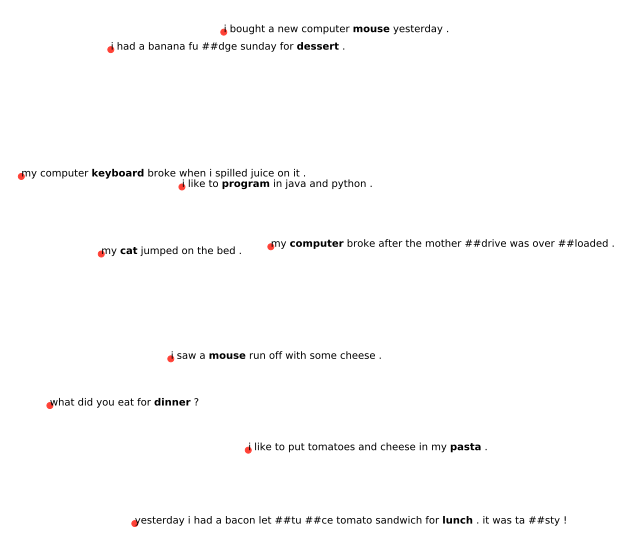

In [61]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(target_embeddings)
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(5, 10))

for word, tokens, x_i, y_i in zip(words, tokens_lst, x, y):
  ax.scatter(x_i, y_i, c=RED)
  ax.annotate(' '.join([f'$\\bf{x}$' if x==word else x for x in tokens]), (x_i, y_i))

ax.axis('off')
plt.show()

[-] Magnitude library  
[-] squeeze(), unsqueeze()  
[-] 